In [2]:
suppressMessages(suppressWarnings(source("../config/config_sing.R")))
show_env()

You are in Singularity: singularity_proj_encode_fcc 
BASE DIRECTORY (FD_BASE): /data/reddylab/Kuei 
WORK DIRECTORY (FD_WORK): /data/reddylab/Kuei/out 
CODE DIRECTORY (FD_CODE): /data/reddylab/Kuei/code 
PATH OF PROJECT (FD_PRJ): /data/reddylab/Kuei/code/Proj_CombEffect_ENCODE_FCC 
PATH OF RESULTS (FD_RES): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc 
PATH OF LOG     (FD_LOG): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc/log 


## Import data

In [4]:
### init
ASSAYS = c("KS91_K562_ASTARRseq", "A001_K562_WSTARRseq", "Tewhey_K562_TileMPRA")
LABELS = c("ASTARR", "WSTARR", "TMPRA")
FOLDER = "coverage_astarrseq_peak_macs_input"

fnames = c(
    "result.Log2FC.raw.deseq.WGS.tsv",
    "result.Log2FC.raw.deseq.WGS.tsv",
    "result.Log2FC.raw.deseq.Merge.tsv"
)
names(fnames) = ASSAYS

### loop and import data
lst = lapply(ASSAYS, function(ASSAY){
    
    ### set file directories
    fdiry = file.path(FD_RES, "results", ASSAY, FOLDER, "summary")
    fname = fnames[ASSAY]
    fpath = file.path(fdiry, fname)

    ### read data
    dat = read_tsv(fpath, show_col_types = FALSE)
    return(dat)
})

names(lst) = LABELS
dat = bind_rows(lst, .id = "Assay")

### assign and show
lst_peak_deseq_starrmpra = lst
dat_peak_deseq_starrmpra = dat
print(dim(dat))
print(table(dat$Assay))
head(dat)

[1] 495260      9

ASTARR  TMPRA WSTARR 
246850   1722 246688 


Assay,Peak,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Dataset
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ASTARR,chr1_100006256_100006880,74.39238,-0.01311792,0.15512423,-0.08456397,9.326080e-01,0.9510236543,NA
ASTARR,chr1_100010437_100010915,48.25931,-0.80687947,0.22174651,-3.63874709,2.739677e-04,0.0008947519,NA
ASTARR,chr1_10002087_10003910,224.35927,-0.34892859,0.09743886,-3.58100041,3.422811e-04,0.0010926173,NA
ASTARR,chr1_100021298_100021629,38.13434,-1.03799571,0.25401013,-4.08643436,4.380534e-05,0.0001707736,NA
ASTARR,chr1_100023727_100023976,32.62049,-0.19100207,0.25625467,-0.74536036,4.560539e-01,0.5497617125,NA
ASTARR,chr1_100027983_100029702,290.98442,-0.18001582,0.09610434,-1.87312902,6.105057e-02,0.1032752224,NA


In [5]:
fdiry = file.path(FD_RES, "results", "region", "KS91_K562_ASTARRseq_peak_macs_input", "summary")
fname = "peak.summary.chipseq_tf_subset.tsv"
fpath = file.path(fdiry, fname)

dat = read_tsv(fpath, show_col_types = FALSE)

dat_peak_annot_chipseq_tf_subset = dat
print(dim(dat))
head(dat)

[1] 270491      4


Peak,Annotation,Label,Count
<chr>,<chr>,<chr>,<dbl>
chr10_100009096_100010466,ChIPseq_TF,YY1,1
chr10_100185017_100187275,ChIPseq_TF,YY1,1
chr10_100228452_100230090,ChIPseq_TF,YY1,1
chr10_100267066_100268374,ChIPseq_TF,YY1,1
chr10_100285974_100287341,ChIPseq_TF,YY1,2
chr10_100346328_100347693,ChIPseq_TF,YY1,1


## Arrange

In [11]:
dat = dat_peak_annot_chipseq_tf_subset
lst = split(dat, dat$Label)

lst_annot = lst
print(length(lst))
head(lst[[1]])

[1] 16


Peak,Annotation,Label,Count
<chr>,<chr>,<chr>,<dbl>
chr10_100009096_100010466,ChIPseq_TF,ATF1,1
chr10_100185017_100187275,ChIPseq_TF,ATF1,2
chr10_100228452_100230090,ChIPseq_TF,ATF1,2
chr10_100267066_100268374,ChIPseq_TF,ATF1,2
chr10_100285974_100287341,ChIPseq_TF,ATF1,2
chr10_100346328_100347693,ChIPseq_TF,ATF1,1


In [12]:
lst = lst_peak_deseq_starrmpra
lst = lapply(lst, function(dat){
    dat = dat %>% dplyr::select(Peak, log2FoldChange)
    return(dat)
})

lst_score = lst
print(length(lst))
head(lst[[1]])

[1] 3


Peak,log2FoldChange
<chr>,<dbl>
chr1_100006256_100006880,-0.01311792
chr1_100010437_100010915,-0.80687947
chr1_10002087_10003910,-0.34892859
chr1_100021298_100021629,-1.03799571
chr1_100023727_100023976,-0.19100207
chr1_100027983_100029702,-0.18001582


## ASTARR

In [41]:
###
idx = "ASTARR"

###
dat_score = lst_score[[idx]]
vec_peak  = lst_score[[idx]] %>% dplyr::arrange(log2FoldChange) %>% dplyr::pull(Peak)

###
dat = dat_score %>% dplyr::select(Peak) %>% distinct
for (idx in names(lst_annot)){
    ant = lst_annot[[idx]]
    vec = ant$Peak
    dat[[idx]] = ifelse(dat$Peak %in% vec, "1", "0")
}
dat = dat %>% tidyr::gather(Label, Value, -Peak)
dat_annot = dat

###
dat_score = dat_score %>% dplyr::mutate(Peak = factor(Peak, levels=vec_peak))
dat_annot = dat_annot %>% dplyr::mutate(Peak = factor(Peak, levels=vec_peak))

print(length(vec_peak))
print(dim(dat_score))
print(dim(dat_annot))

[1] 246850
[1] 246850      2
[1] 3949600       3


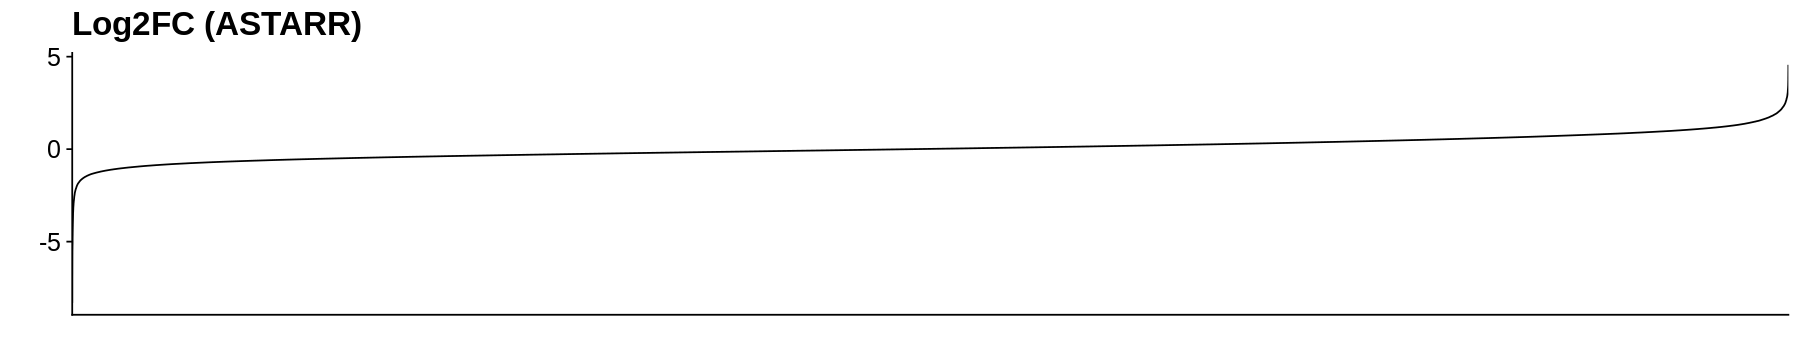

In [42]:
dat = dat_score
gpt = ggplot(dat, aes(x=Peak, y=log2FoldChange, group = 1)) +
    geom_line() +
    labs(x="", y="", title = "Log2FC (ASTARR)") +
    theme_cowplot() +
    theme(axis.text.x  = element_blank(),
          axis.text.y  = element_text(size=15),
          axis.ticks.x = element_blank(),
          plot.title   = element_text(size=20))
gpt_score = gpt

options(repr.plot.height=3, repr.plot.width=15)
print(gpt)

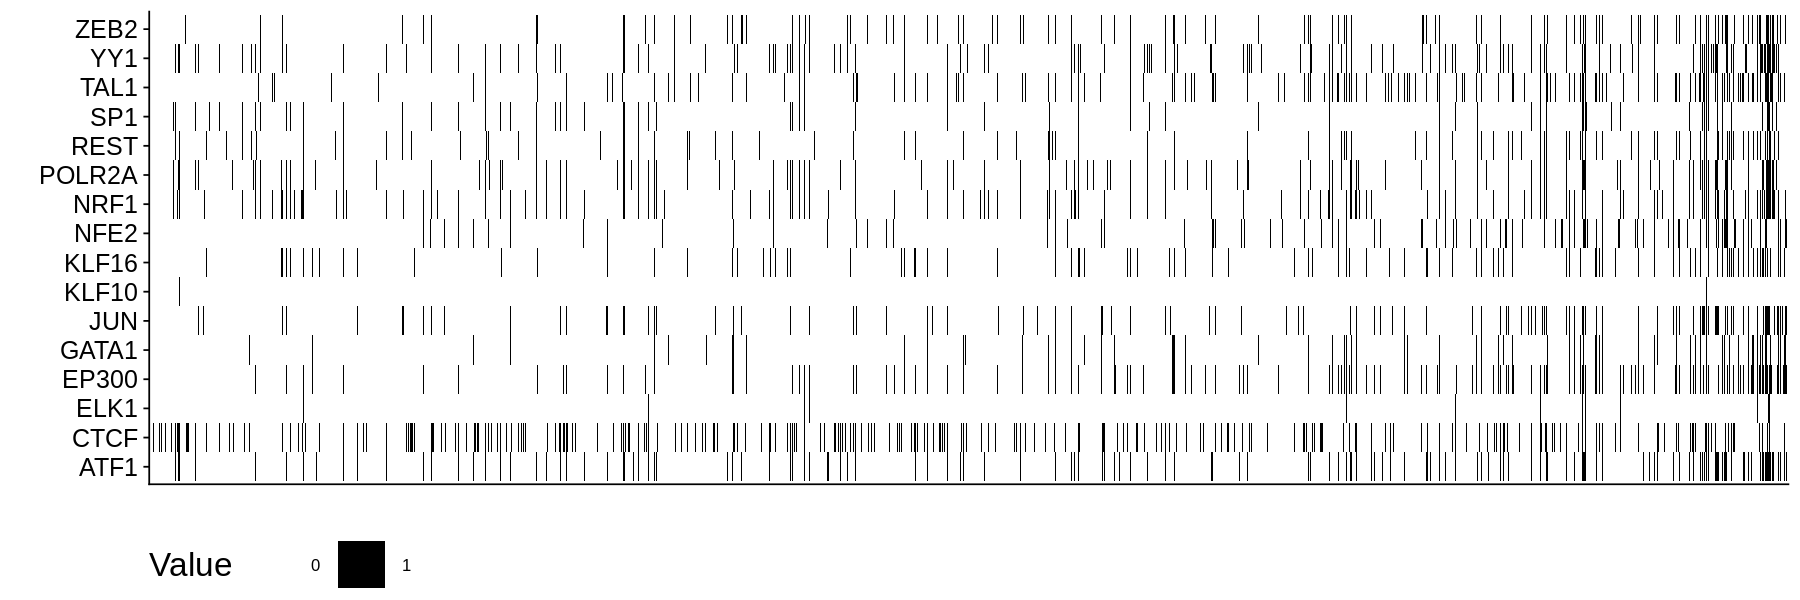

In [18]:
dat = dat_annot
gpt = ggplot(dat, aes(x=Peak, y=Label, fill=Value)) +
    geom_tile() +
    scale_fill_manual(values = c("1" = "black", "0" = "white")) +
    labs(x="", y="") +
    theme_cowplot() +
    theme(axis.text.x = element_blank(),
          axis.text.y = element_text(size=15),
          axis.ticks.x = element_blank(),
          legend.position = "bottom",
          legend.key.size = unit(1, 'cm'),
          legend.title = element_text(size=20),
          legend.text  = element_text(size=10))
gpt_annot = gpt

options(repr.plot.height=5, repr.plot.width=15)
print(gpt)

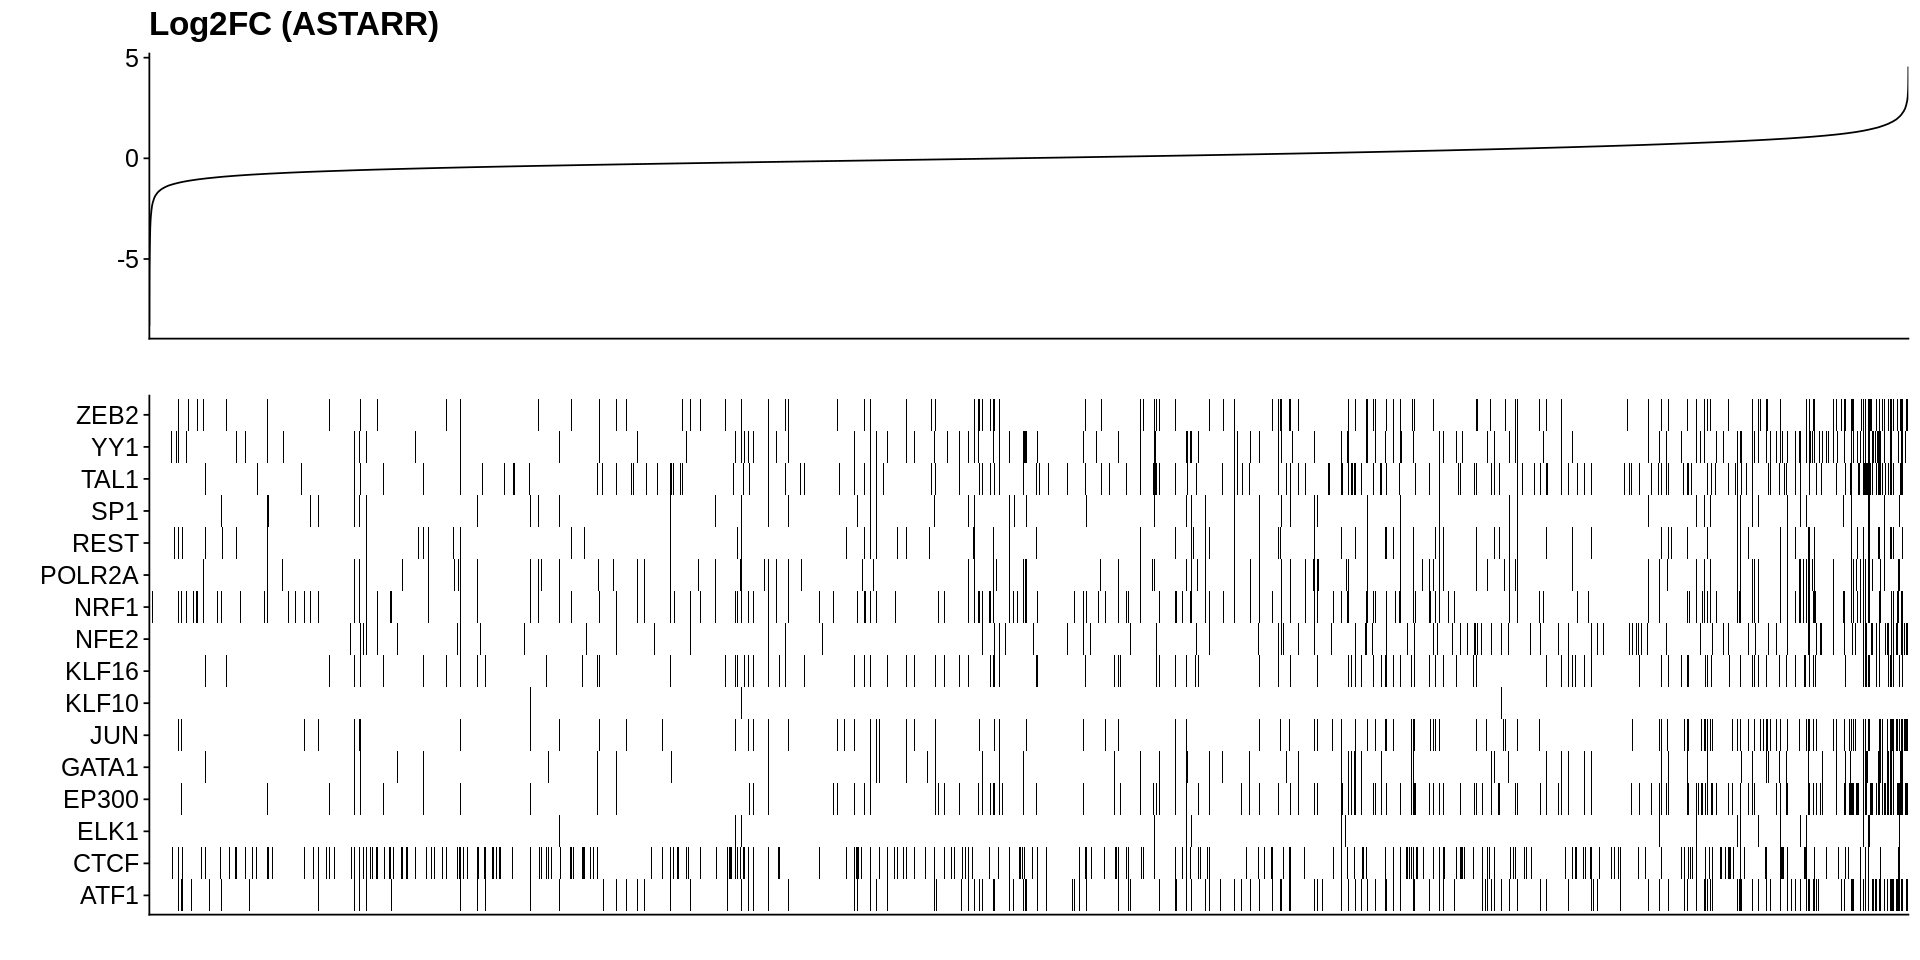

In [27]:
options(repr.plot.height=8, repr.plot.width=16)
plot_grid(
    gpt_score + theme(legend.position = "none"), 
    gpt_annot + theme(legend.position = "none"), 
    ncol  = 1,
    align = "v",
    rel_heights = c(2, 3))

In [58]:
vec_annot = lst_annot[["REST"]] %>% dplyr::pull(Peak)
vec_score = dat_score %>% tibble::deframe()
print(length(vec_annot))
print(length(vec_score))
#options(repr.plot.height=10, repr.plot.width=50)
#plotEnrichment(vec_annot, vec_score)

[1] 14306
[1] 246850


## WSTARR

In [39]:
###
idx = "WSTARR"

###
dat_score = lst_score[[idx]]
vec_peak  = lst_score[[idx]] %>% dplyr::arrange(log2FoldChange) %>% dplyr::pull(Peak)

###
dat = dat_score %>% dplyr::select(Peak) %>% distinct
for (idx in names(lst_annot)){
    ant = lst_annot[[idx]]
    vec = ant$Peak
    dat[[idx]] = ifelse(dat$Peak %in% vec, "1", "0")
}
dat = dat %>% tidyr::gather(Label, Value, -Peak)
dat_annot = dat

###
dat_score = dat_score %>% dplyr::mutate(Peak = factor(Peak, levels=vec_peak))
dat_annot = dat_annot %>% dplyr::mutate(Peak = factor(Peak, levels=vec_peak))

print(length(vec_peak))
print(dim(dat_score))
print(dim(dat_annot))

[1] 246688
[1] 246688      2
[1] 3947008       3


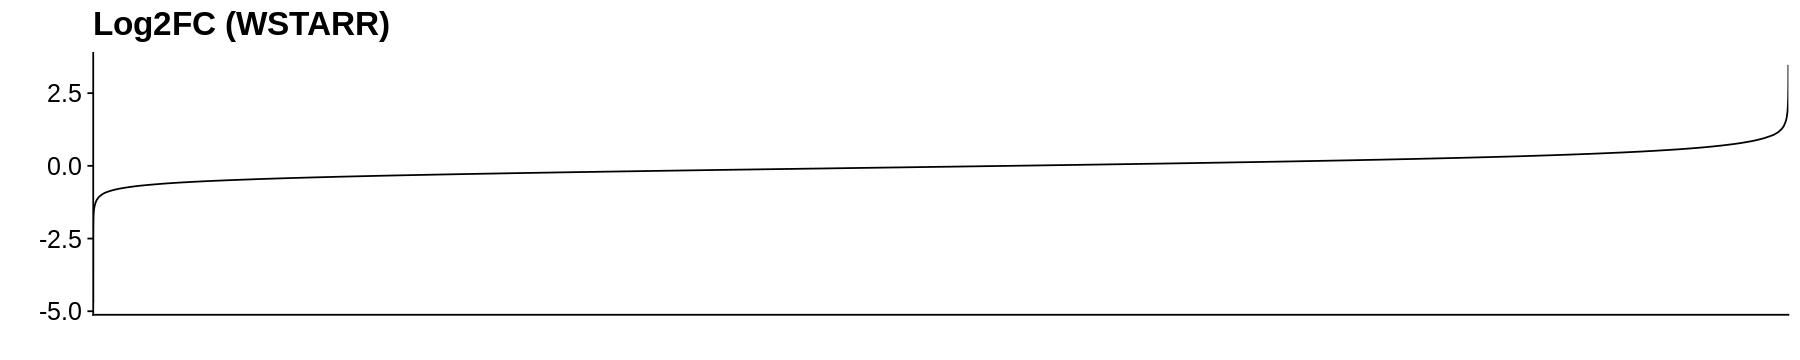

In [31]:
dat = dat_score
gpt = ggplot(dat, aes(x=Peak, y=log2FoldChange, group = 1)) +
    geom_line() +
    labs(x="", y="", title = "Log2FC (WSTARR)") +
    theme_cowplot() +
    theme(axis.text.x  = element_blank(),
          axis.text.y  = element_text(size=15),
          axis.ticks.x = element_blank(),
          plot.title   = element_text(size=20))
gpt_score = gpt

options(repr.plot.height=3, repr.plot.width=15)
print(gpt)

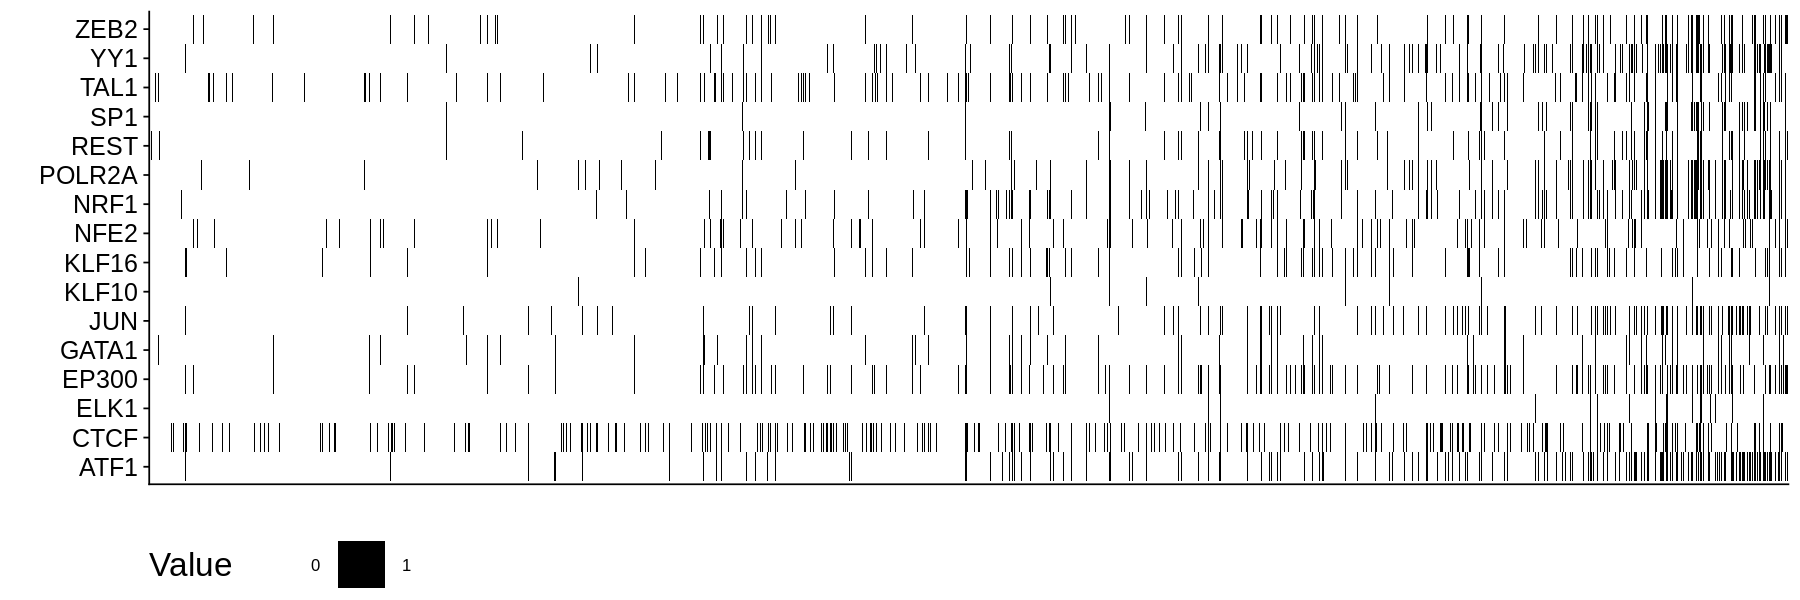

In [30]:
dat = dat_annot
gpt = ggplot(dat, aes(x=Peak, y=Label, fill=Value)) +
    geom_tile() +
    scale_fill_manual(values = c("1" = "black", "0" = "white")) +
    labs(x="", y="") +
    theme_cowplot() +
    theme(axis.text.x = element_blank(),
          axis.text.y = element_text(size=15),
          axis.ticks.x = element_blank(),
          legend.position = "bottom",
          legend.key.size = unit(1, 'cm'),
          legend.title = element_text(size=20),
          legend.text  = element_text(size=10))
gpt_annot = gpt

options(repr.plot.height=5, repr.plot.width=15)
print(gpt)

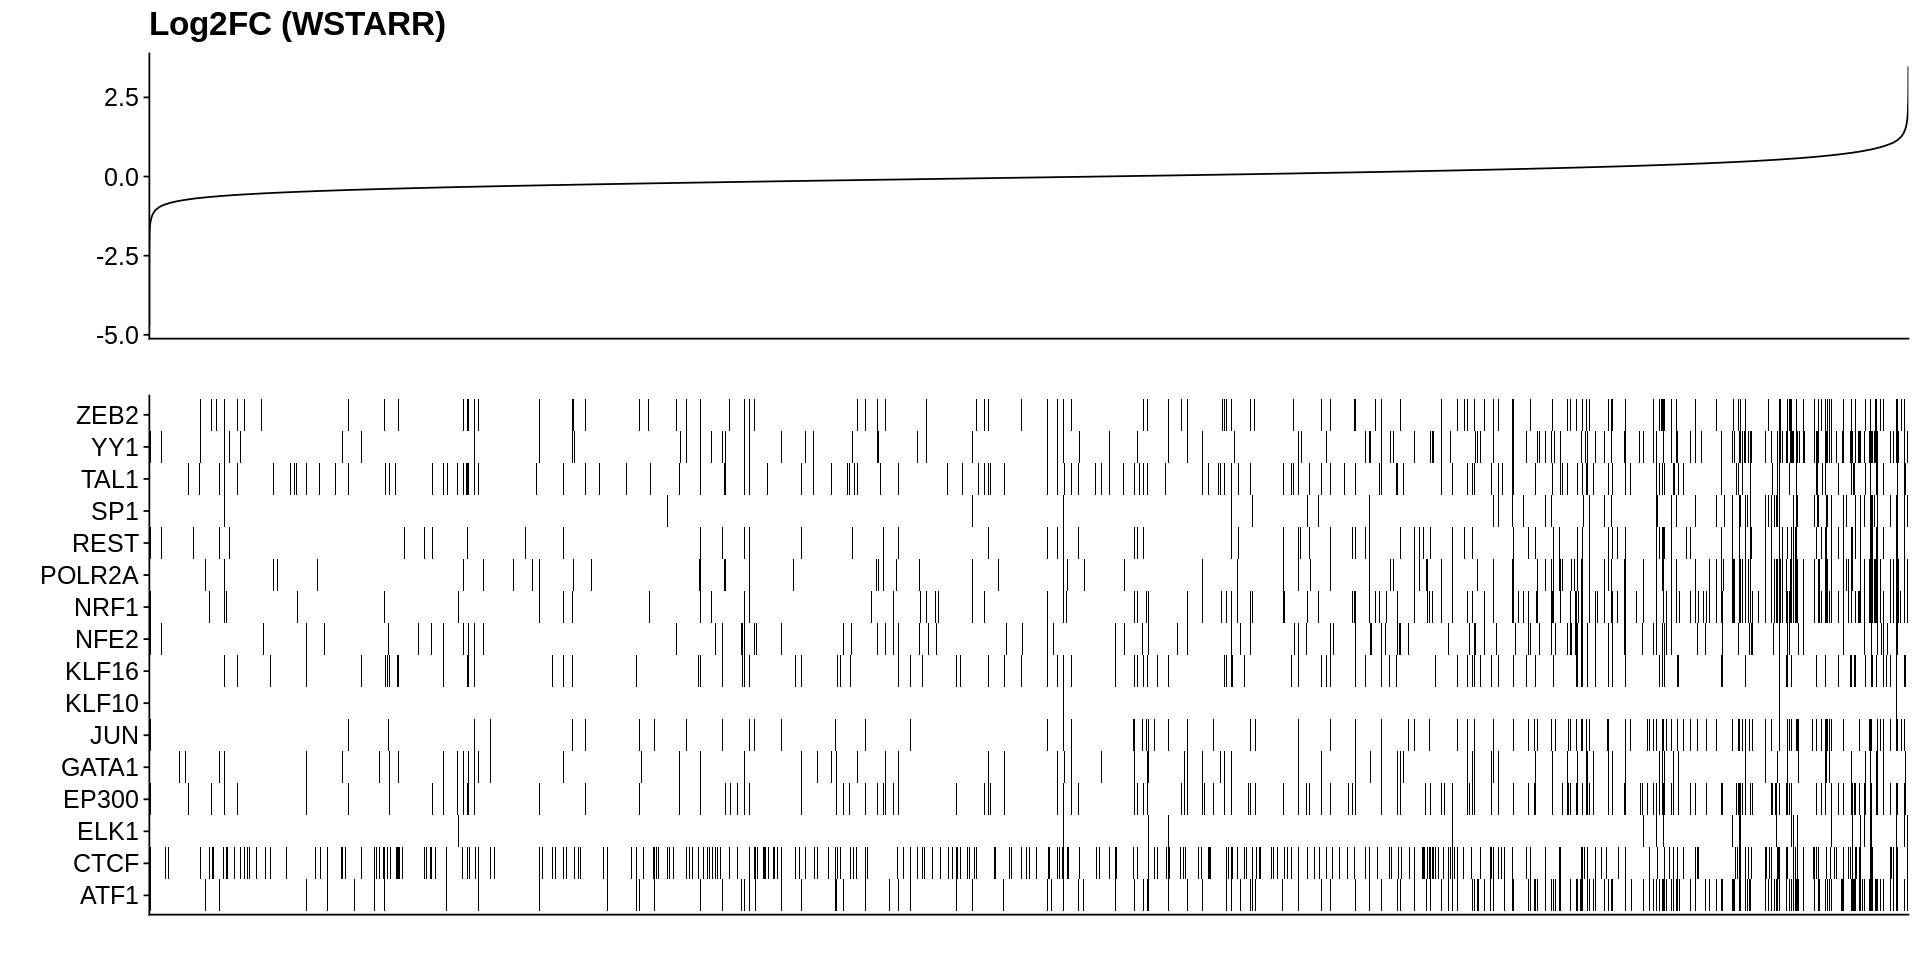

In [32]:
options(repr.plot.height=8, repr.plot.width=16)
plot_grid(
    gpt_score + theme(legend.position = "none"), 
    gpt_annot + theme(legend.position = "none"), 
    ncol  = 1,
    align = "v",
    rel_heights = c(2, 3))

## TMPRA

In [40]:
###
idx = "TMPRA"

###
dat_score = lst_score[[idx]]
vec_peak  = lst_score[[idx]] %>% dplyr::arrange(log2FoldChange) %>% dplyr::pull(Peak)

###
dat = dat_score %>% dplyr::select(Peak) %>% distinct
for (idx in names(lst_annot)){
    ant = lst_annot[[idx]]
    vec = ant$Peak
    dat[[idx]] = ifelse(dat$Peak %in% vec, "1", "0")
}
dat = dat %>% tidyr::gather(Label, Value, -Peak)
dat_annot = dat

###
dat_score = dat_score %>% dplyr::mutate(Peak = factor(Peak, levels=vec_peak))
dat_annot = dat_annot %>% dplyr::mutate(Peak = factor(Peak, levels=vec_peak))

print(length(vec_peak))
print(dim(dat_score))
print(dim(dat_annot))

[1] 1722
[1] 1722    2
[1] 27552     3


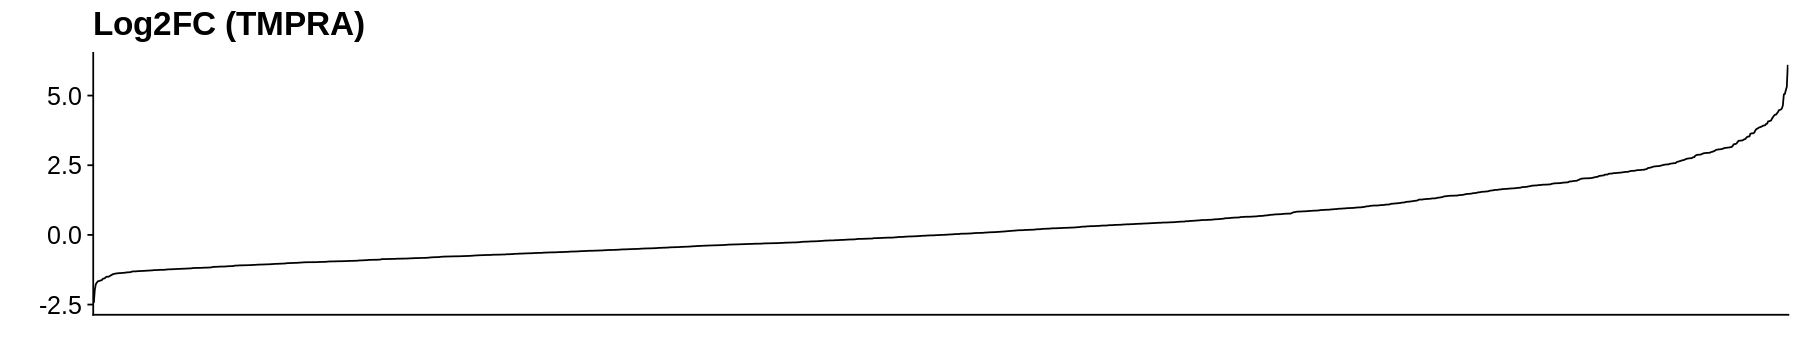

In [34]:
dat = dat_score
gpt = ggplot(dat, aes(x=Peak, y=log2FoldChange, group = 1)) +
    geom_line() +
    labs(x="", y="", title = "Log2FC (TMPRA)") +
    theme_cowplot() +
    theme(axis.text.x  = element_blank(),
          axis.text.y  = element_text(size=15),
          axis.ticks.x = element_blank(),
          plot.title   = element_text(size=20))
gpt_score = gpt

options(repr.plot.height=3, repr.plot.width=15)
print(gpt)

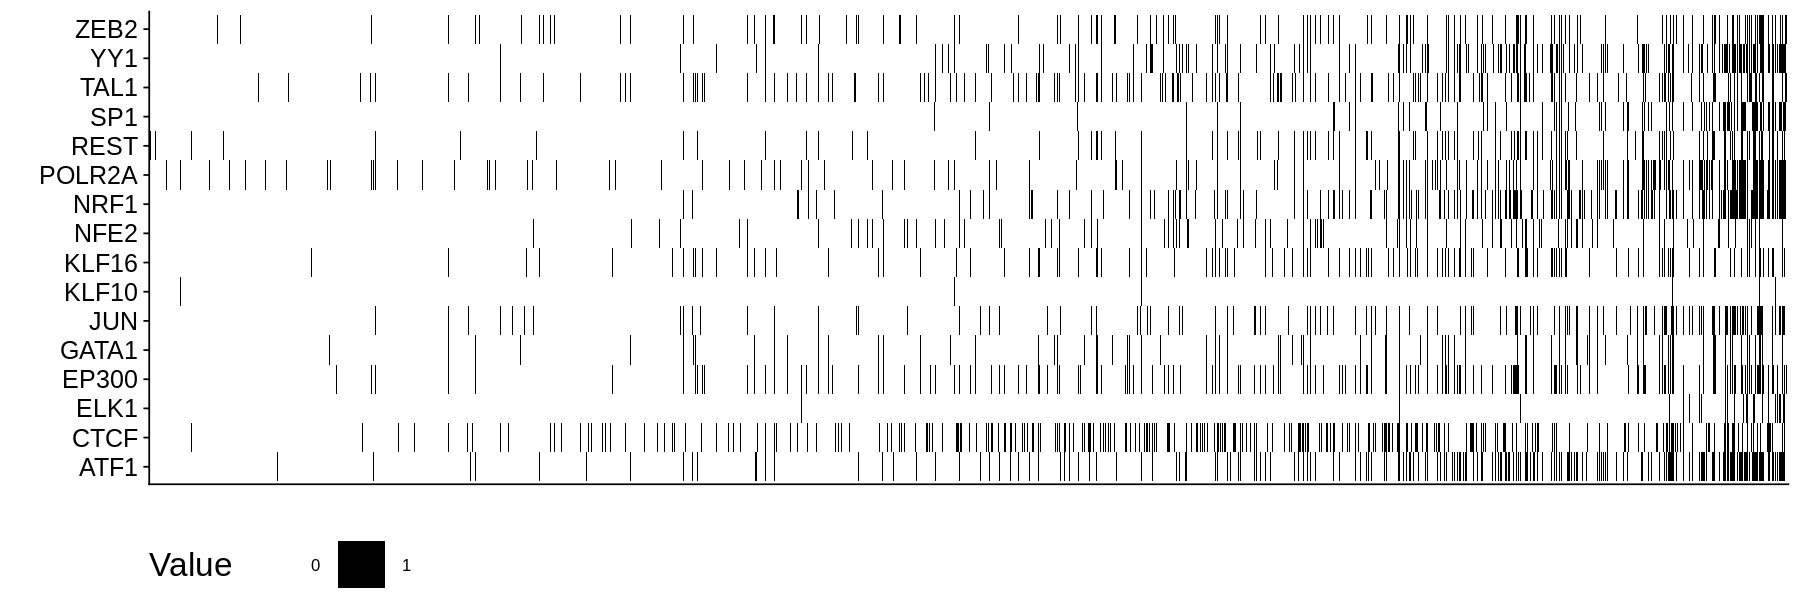

In [35]:
dat = dat_annot
gpt = ggplot(dat, aes(x=Peak, y=Label, fill=Value)) +
    geom_tile() +
    scale_fill_manual(values = c("1" = "black", "0" = "white")) +
    labs(x="", y="") +
    theme_cowplot() +
    theme(axis.text.x = element_blank(),
          axis.text.y = element_text(size=15),
          axis.ticks.x = element_blank(),
          legend.position = "bottom",
          legend.key.size = unit(1, 'cm'),
          legend.title = element_text(size=20),
          legend.text  = element_text(size=10))
gpt_annot = gpt

options(repr.plot.height=5, repr.plot.width=15)
print(gpt)

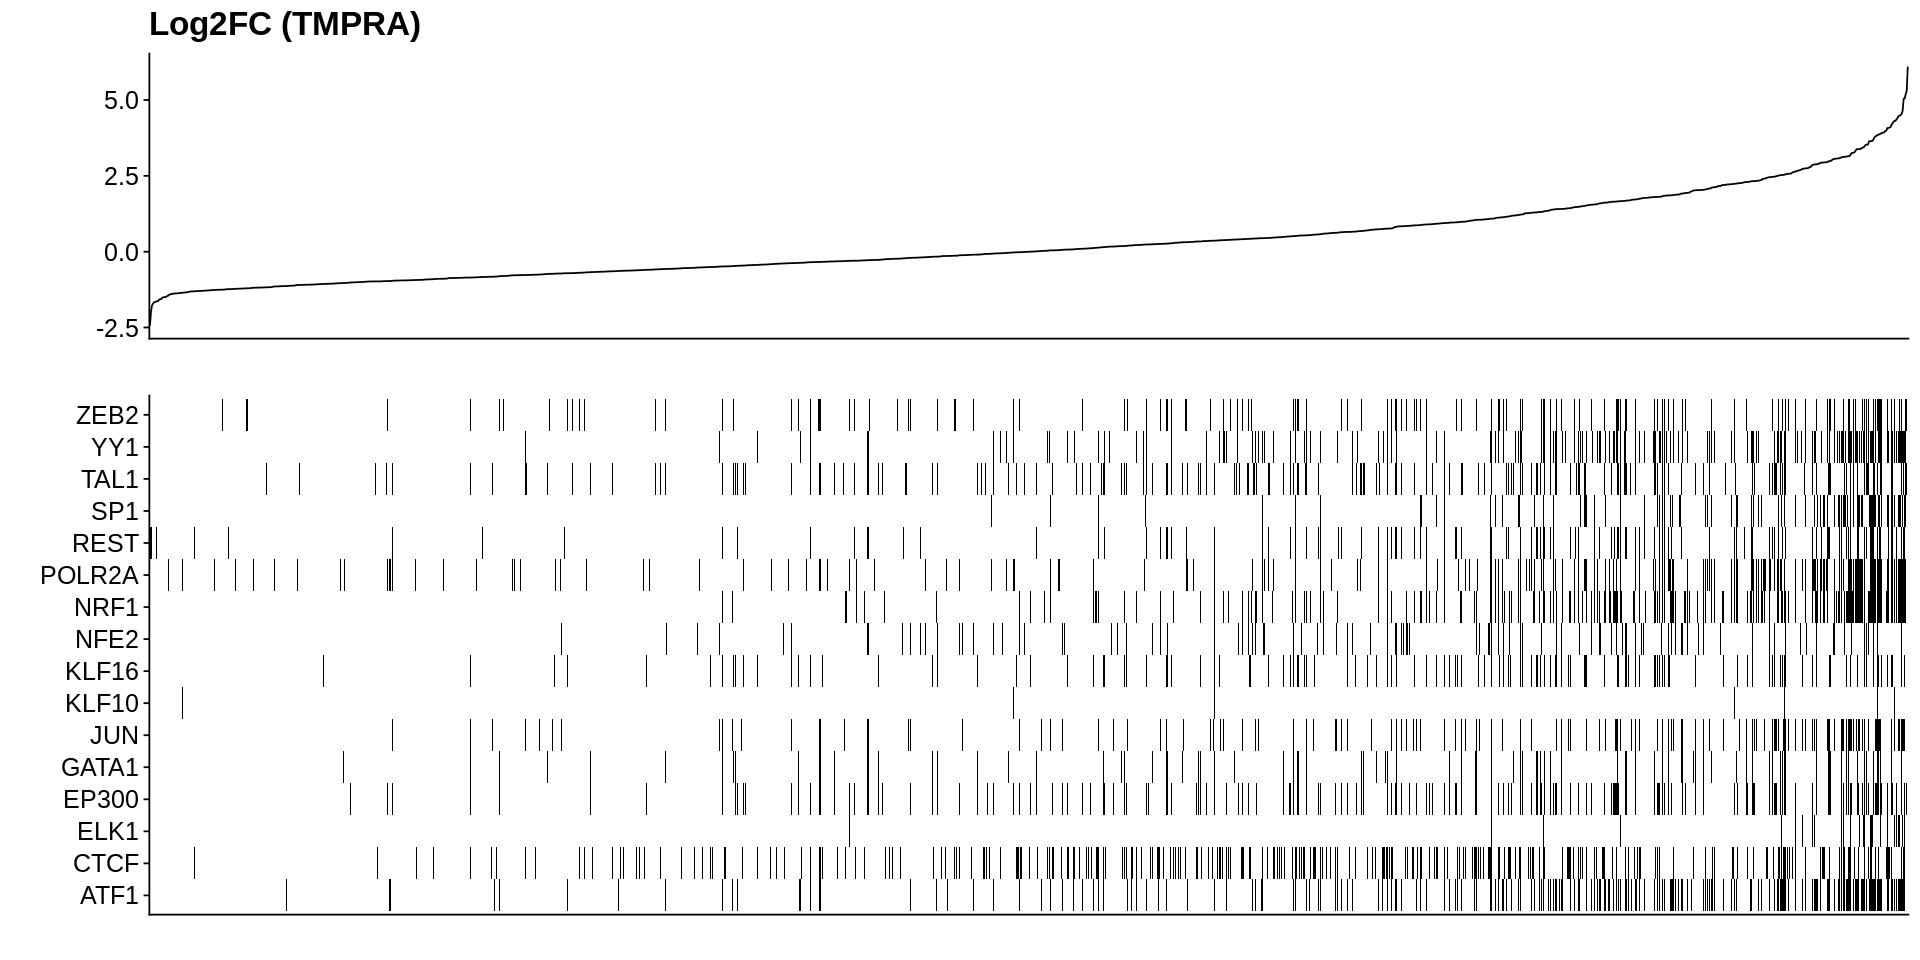

In [36]:
options(repr.plot.height=8, repr.plot.width=16)
plot_grid(
    gpt_score + theme(legend.position = "none"), 
    gpt_annot + theme(legend.position = "none"), 
    ncol  = 1,
    align = "v",
    rel_heights = c(2, 3))

In [ ]:
dat = dat_astarr
dat = dat %>% dplyr::select(Peak) %>% distinct

for (idx in names(lst_annot)[1:3]){
    ant = lst_annot[[idx]]
    vec = ant$Peak
    dat[[idx]] = ifelse(dat$Peak %in% vec, "1", "0")
}

dat = dat %>% tidyr::gather(Label, Value, -Peak)

dat_annot = dat
print(dim(dat))
head(dat)

In [10]:
idx   = "ASTARR"

peaks     = lst_score[[idx]] %>% dplyr::arrange(log2FoldChange) %>% dplyr::pull(Peak)
dat_score = lst_score[[idx]] %>% dplyr::mutate()
dat_annot = lst_annot[[idx]] %>%

In [19]:
dat = dat_peak_deseq_starrmpra
lst = split(dat, dat$Assay)
dat = lst[["ASTARR"]]
dat = dat %>% 
    dplyr::select(Peak, log2FoldChange) %>%
    dplyr::arrange(log2FoldChange)
dat$Peak = factor(dat$Peak, levels=dat$Peak)

dat_astarr = dat
print(dim(dat))
head(dat)

[1] 246850      2


Peak,log2FoldChange
<fct>,<dbl>
chr21_8444383_8444725,-8.311321
chrX_268311_270667,-8.125026
chr21_13696841_13697094,-7.749331
chr21_6467444_6467714,-7.511671
chr8_7783784_7784082,-7.114224
chr11_3654355_3654628,-6.956024


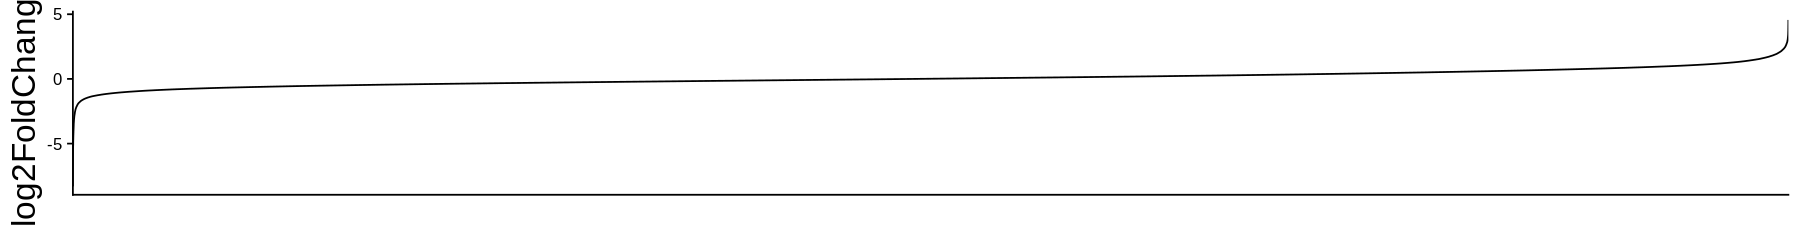

In [21]:
gpt = ggplot(dat, aes(x=Peak, y=log2FoldChange, group = 1)) +
    geom_line() +
    labs(x="", y="log2FoldChange") +
    theme_cowplot() +
    theme(axis.text.x  = element_blank(),
          axis.text.y  = element_text(size=10),
          axis.ticks.x = element_blank(),
          axis.title.y = element_text(size=20))

options(repr.plot.height=2, repr.plot.width=15)
print(gpt)

In [23]:
dat = dat_astarr
dat = dat %>% dplyr::select(Peak) %>% distinct

for (idx in names(lst_annot)[1:3]){
    ant = lst_annot[[idx]]
    vec = ant$Peak
    dat[[idx]] = ifelse(dat$Peak %in% vec, "1", "0")
}

dat = dat %>% tidyr::gather(Label, Value, -Peak)

dat_annot = dat
print(dim(dat))
head(dat)

[1] 740550      3


Peak,Label,Value
<fct>,<chr>,<chr>
chr21_8444383_8444725,ATF1,0
chrX_268311_270667,ATF1,0
chr21_13696841_13697094,ATF1,0
chr21_6467444_6467714,ATF1,0
chr8_7783784_7784082,ATF1,0
chr11_3654355_3654628,ATF1,0


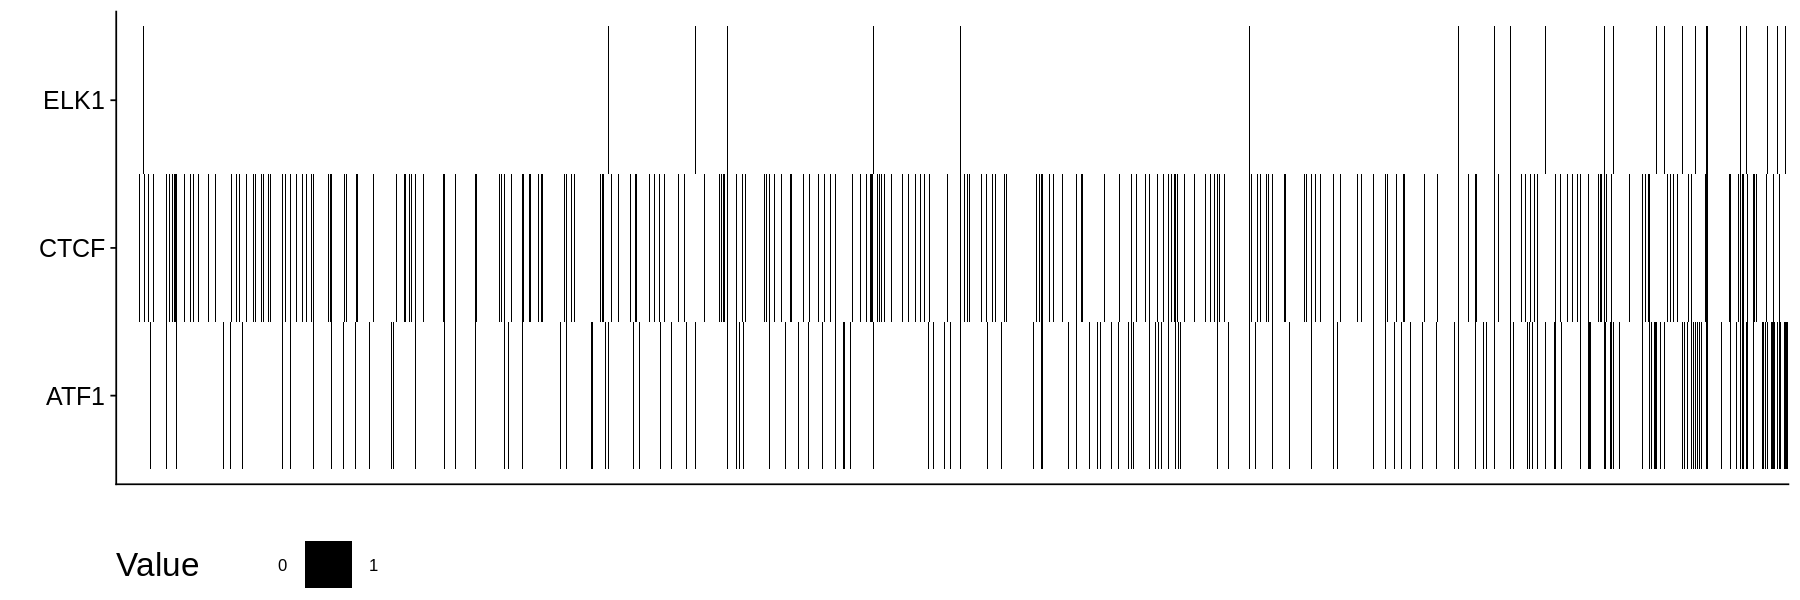

In [24]:
dat = dat_annot

#dat = dat %>% dplyr::mutate(
#    Peak  = factor(Peak,  levels=peaks),
#    Annot = factor(Label, levels=annots)
#)
    
gpt = ggplot(dat, aes(x=Peak, y=Label, fill=Value)) +
    geom_tile() +
    scale_fill_manual(values = c("1" = "black", "0" = "white")) +
    labs(x="", y="") +
    theme_cowplot() +
    theme(axis.text.x = element_blank(),
          axis.text.y = element_text(size=15),
          axis.ticks.x = element_blank(),
          legend.position = "bottom",
          legend.key.size = unit(1, 'cm'),
          legend.title = element_text(size=20),
          legend.text = element_text(size=10))

gpt_annot = gpt
options(repr.plot.height=5, repr.plot.width=15)
print(gpt)

In [ ]:
dat = dat_astarr
dat = dat %>% dplyr::slice_sample(n = 1000)
dat = dat %>% 
    dplyr::mutate(
        Name  = "Input",
        Score = Input_Score
    ) %>% 
    dplyr::arrange(Score)
dat$Peak = factor(dat$Peak, levels=dat$Peak)

gpt = ggplot(dat, aes(x=Peak, y=Score, group = 1)) +
        geom_line() +
        labs(x="", y="Input Score") +
        theme_cowplot() +
        theme(axis.text.x  = element_blank(),
              axis.text.y  = element_text(size=10),
              axis.ticks.x = element_blank(),
              axis.title.y = element_text(size=20))